In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

In [2]:
def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

def get_column_from_many_csv(filenames, col_num):
    intermediate_df = pd.DataFrame()
    for i, path in enumerate(filenames):
        df = pd.read_csv(path, skiprows=1)
        intermediate_df[i] = df.iloc[:, col_num]
    return intermediate_df

In [3]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [4]:
def plot_ac_u_comp(df, clean=3, smooth_u=0, smooth_ac=0, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    _, ax = plt.subplots(figsize=(15, 5))

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, smooth_ac)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time
    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells unified memory', c='black', ls='-.')


    if smooth_u:
        new_iter_no, u_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, smooth_u)
    else:
        new_iter_no, u_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.u_iter_time
    ax.plot(new_iter_no, u_iter_time_smooth, label='Non-active cells unified memory', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    first_100 = (cleaned_df['ac_coverage'] == 1).idxmax()
    # if draw_v_lines:
    #     ax.axvline(x=iteration_no[first_100], lw=1, ls='--', c='black')
    #     ax.text(iteration_no[first_100] - 150, 1300, 'All cells are active', rotation=90)

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['u_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(iteration_no[cross_point] - x_lim[1] * .01,
                (y_lim[1] - y_lim[0]) * .02 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      list(range(0, cleaned_df.shape[0], round(cleaned_df.shape[0] / 6)))
      + [cross_point, first_100, len(cleaned_df) - 1]
    )
    xticks = [iteration_no[i] for i in xs]

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Time of 10 iterations [ms]')
    ax.set_xticks(xticks)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0] * 100:.2f}%'
        for i in xticks
    ])

    plt.legend()
    plt.show()

### Averaged standard results (100)

In [6]:
ac_to_avg = glob('unical_mount_point/standard_test/active_cells_32_4000_9000_6_*.csv')
u_to_avg = glob('unical_mount_point/standard_test/unified_memory_32_4000_9000_6_*.csv')

avg_100_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])
avg_100_comp.drop(['x', 'y'], axis=1, inplace=True)

avg_100_comp['ac_iter_time'] = get_column_from_many_csv(ac_to_avg, 2).median(axis=1)
avg_100_comp['u_iter_time'] = get_column_from_many_csv(u_to_avg, 2).median(axis=1)

avg_100_comp.describe()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
count,900.000000,900.000000,899.000000,899.000000
mean,4496.000000,0.675589,26.587875,26.109566
std,2599.519186,0.325589,9.772299,2.801717
min,1.000000,0.000002,14.000000,23.000000
25%,2248.500000,0.398134,21.000000,23.000000
50%,4496.000000,0.780058,25.000000,26.000000
75%,6743.500000,0.998136,33.000000,29.000000
max,8991.000000,1.000000,129.500000,32.000000


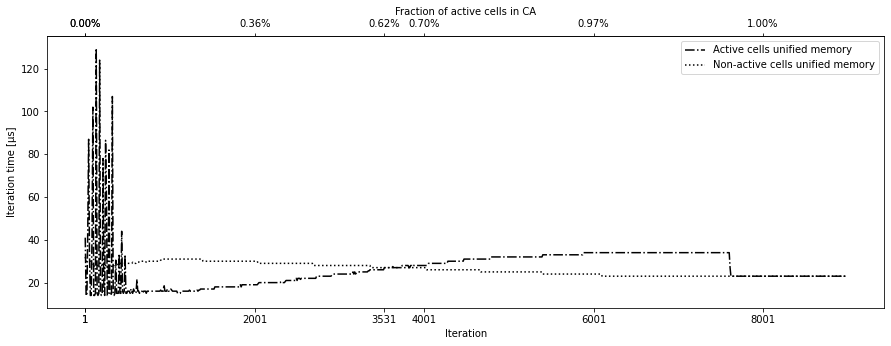

In [22]:
plot_ac_u_comp(avg_100_comp, clean=False, draw_v_lines=False)

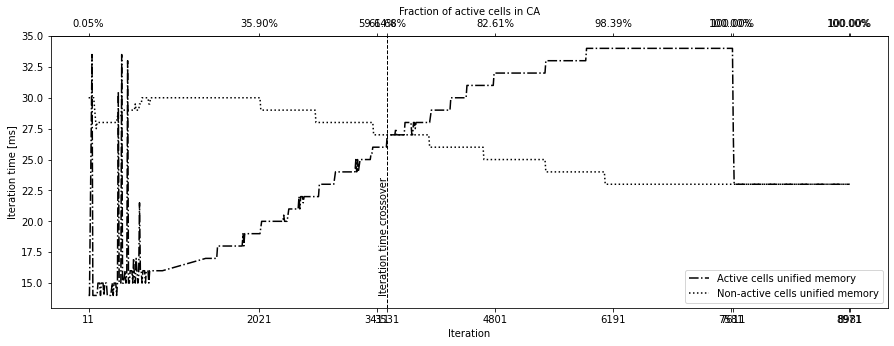

In [107]:
plot_ac_u_comp(avg_100_comp, clean=1.5, draw_v_lines=True)

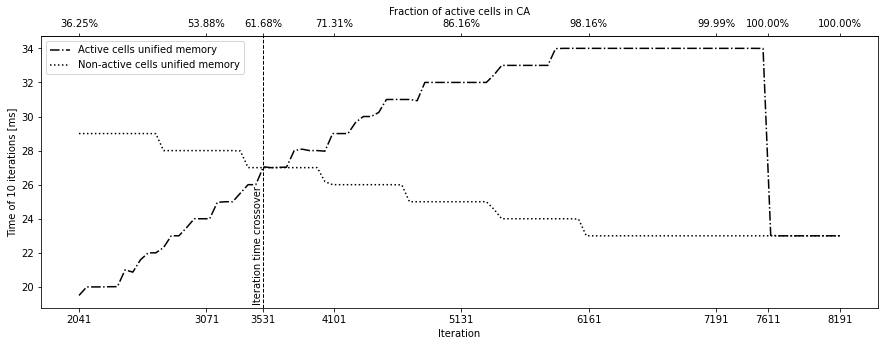

In [211]:
plot_ac_u_comp(avg_100_comp.iloc[60:820], clean=1.5, smooth_ac=100, smooth_u=100, draw_v_lines=True)

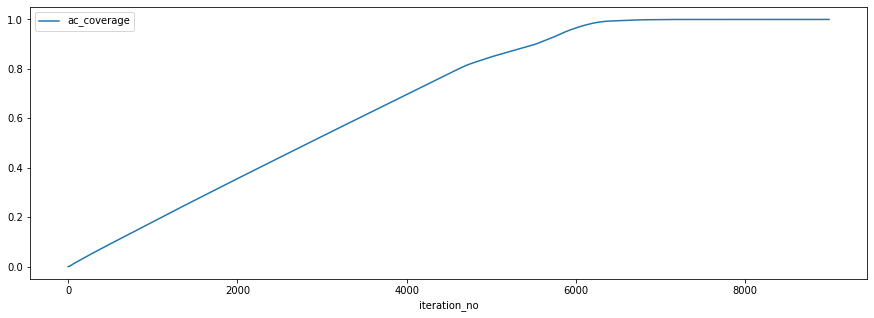

In [114]:
_, ax = plt.subplots(figsize=(15, 5))
avg_100_comp.plot(x='iteration_no', y='ac_coverage', ax=ax)

### Averaged stress results

In [10]:
ac_to_avg = glob('unical_mount_point/stress_test/active_cells_loop_*')

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
inter_df = pd.DataFrame()
ac_trans_df = pd.DataFrame()
ac_find_df = pd.DataFrame()

for i, path in enumerate(ac_to_avg):
    df = pd.read_csv(path, skiprows=1, names=active_cell_cols)
    inter_df[i] = df.ac_iter_time
    ac_trans_df[i] = df.ac_trans_time
    ac_find_df[i] = df.ac_find_time

avg_20_loop_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=active_cell_cols)

avg_20_loop_comp['ac_iter_time'] = inter_df.min(axis=1)
avg_20_loop_comp['ac_trans_time'] = ac_trans_df.min(axis=1)
avg_20_loop_comp['ac_find_time'] = ac_find_df.min(axis=1)

u_to_avg = glob('unical_mount_point/stress_test/unified_loop_*')

avg_20_loop_comp['u_iter_time'] = get_column_from_many_csv(u_to_avg, 2).min(axis=1)

first_100 = (avg_20_loop_comp['ac_coverage'] == 100).idxmax()
avg_20_loop_comp = avg_20_loop_comp.iloc[:first_100 + 1]

avg_20_loop_comp.describe()

,iteration_no,ac_coverage,ac_iter_time,ac_trans_time,ac_find_time,u_iter_time
count,797.000000,797.000000,797.000000,797.0,797.0,0.0
mean,3981.000000,63.334223,-893352.233375,0.0,0.0,NaN
std,2302.183746,32.261831,266913.044471,0.0,0.0,NaN
min,1.000000,0.000225,-987700.000000,0.0,0.0,NaN
25%,1991.000000,35.374950,-979822.000000,0.0,0.0,NaN
50%,3981.000000,69.328350,-972170.000000,0.0,0.0,NaN
75%,5971.000000,95.716175,-968565.000000,0.0,0.0,NaN
max,7961.000000,100.000000,57511.000000,0.0,0.0,NaN


ValueError: attempt to get argmax of an empty sequence

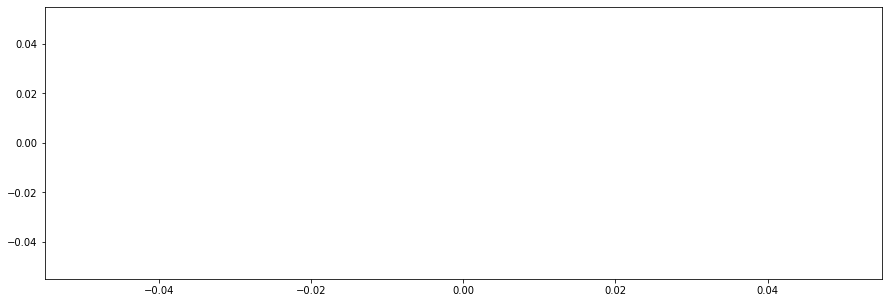

In [11]:
plot_ac_u_comp(avg_20_loop_comp, clean=True, draw_v_lines=True)

In [ ]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(avg_20_loop_comp.iteration_no, avg_20_loop_comp.ac_trans_time)
ax.plot(avg_20_loop_comp.iteration_no, avg_20_loop_comp.ac_find_time)

### Crossover

In [161]:
crossover_ac = sorted(glob('unical_mount_point/coverage_tests/active_cells_*'))
ca_sizes = sorted(set(filepath.split('_')[-6] for filepath in crossover_ac))

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
crossovers = dict()

for ca_size in ca_sizes:
    crossover_ac = sorted(glob(f'unical_mount_point/coverage_tests/active_cells_32_{ca_size}*'))
    crossover_u = sorted(glob(f'unical_mount_point/coverage_tests/unified_memory_32_{ca_size}*'))

    avg_crossover_df = pd.DataFrame()
    avg_crossover_df['ac_iter_time'] = get_column_from_many_csv(crossover_ac, 2).quantile([.25], axis=1).T.iloc[:,0]
    avg_crossover_df['ac_coverage'] = pd.read_csv(crossover_ac[0], skiprows=1, names=active_cell_cols).ac_coverage
    avg_crossover_df['u_iter_time'] = get_column_from_many_csv(crossover_u, 2).quantile([.25], axis=1).T.iloc[:,0]

    crossover_idx = ((avg_crossover_df.ac_iter_time - avg_crossover_df.u_iter_time) >= 0).iloc[300:].idxmax()

    coverage = avg_crossover_df.ac_coverage.iloc[crossover_idx]

    crossovers[ca_size] = coverage
crossovers

{'4000': 0.625194,
 '5000': 0.65561856,
 '5500': 0.6594158016528929,
 '6000': 0.6741495,
 '6500': 0.670488923076923,
 '6750': 0.6620801316872429,
 '7000': 0.688017306122449,
 '7250': 0.662195900118906,
 '7500': 0.66518784}

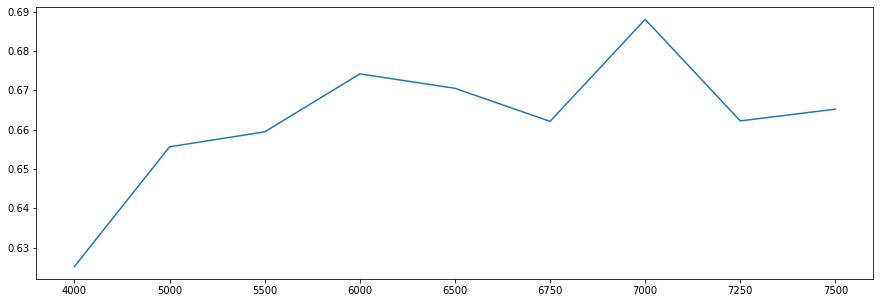

In [162]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(list(crossovers.keys()), list(crossovers.values()))

In [5]:
crossover_ac = sorted(glob('unical_mount_point/coverage_tests/active_cells_*'))
ca_sizes = sorted(set(filepath.split('_')[-6] for filepath in crossover_ac))

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
quantiles = np.array(range(0, 101, 10)) / 100
covers_all = {q: dict() for q in quantiles}

for ca_size in ca_sizes:
    crossover_ac = sorted(glob(f'unical_mount_point/coverage_tests/active_cells_32_{ca_size}*'))
    crossover_u = sorted(glob(f'unical_mount_point/coverage_tests/unified_memory_32_{ca_size}*'))

    ac_df = get_column_from_many_csv(crossover_ac, 2).quantile(quantiles, axis=1).T
    u_df = get_column_from_many_csv(crossover_u, 2).quantile(quantiles, axis=1).T
    for i, quantile in enumerate(quantiles):

        avg_crossover_df = pd.DataFrame()
        avg_crossover_df['ac_coverage'] = pd.read_csv(crossover_ac[0], skiprows=1, names=active_cell_cols).ac_coverage
        avg_crossover_df['ac_iter_time'] = ac_df.iloc[:, i]
        avg_crossover_df['u_iter_time'] = u_df.iloc[:, i]

        crossover_idx = ((avg_crossover_df.ac_iter_time - avg_crossover_df.u_iter_time) >= 0).iloc[300:].idxmax()
        coverage = avg_crossover_df.ac_coverage.iloc[crossover_idx].copy()

        covers_all[quantile][ca_size] = coverage * 100
covers_all

{0.0: {'4000': 69.960375,
  '5000': 65.947648,
  '5500': 65.9415801652893,
  '6000': 68.091975,
  '6500': 67.0488923076923,
  '6750': 66.40798683127571,
  '7000': 68.80173061224491,
  '7250': 68.0899120095125,
  '7500': 66.904576},
 0.1: {'4000': 67.58505,
  '5000': 65.750016,
  '5500': 65.9415801652893,
  '6000': 67.41494999999999,
  '6500': 67.0488923076923,
  '6750': 66.40798683127571,
  '7000': 68.80173061224491,
  '7250': 67.26145826397149,
  '7500': 66.904576},
 0.2: {'4000': 63.36495,
  '5000': 65.56185599999999,
  '5500': 65.9415801652893,
  '6000': 67.41494999999999,
  '6500': 67.0488923076923,
  '6750': 66.40798683127571,
  '7000': 68.80173061224491,
  '7250': 66.21959001189059,
  '7500': 66.71104},
 0.3: {'4000': 62.519400000000005,
  '5000': 65.366528,
  '5500': 66.10850909090911,
  '6000': 67.41494999999999,
  '6500': 67.0488923076923,
  '6750': 66.20801316872429,
  '7000': 68.80173061224491,
  '7250': 66.43547015457789,
  '7500': 66.518784},
 0.4: {'4000': 61.0047,
  '500

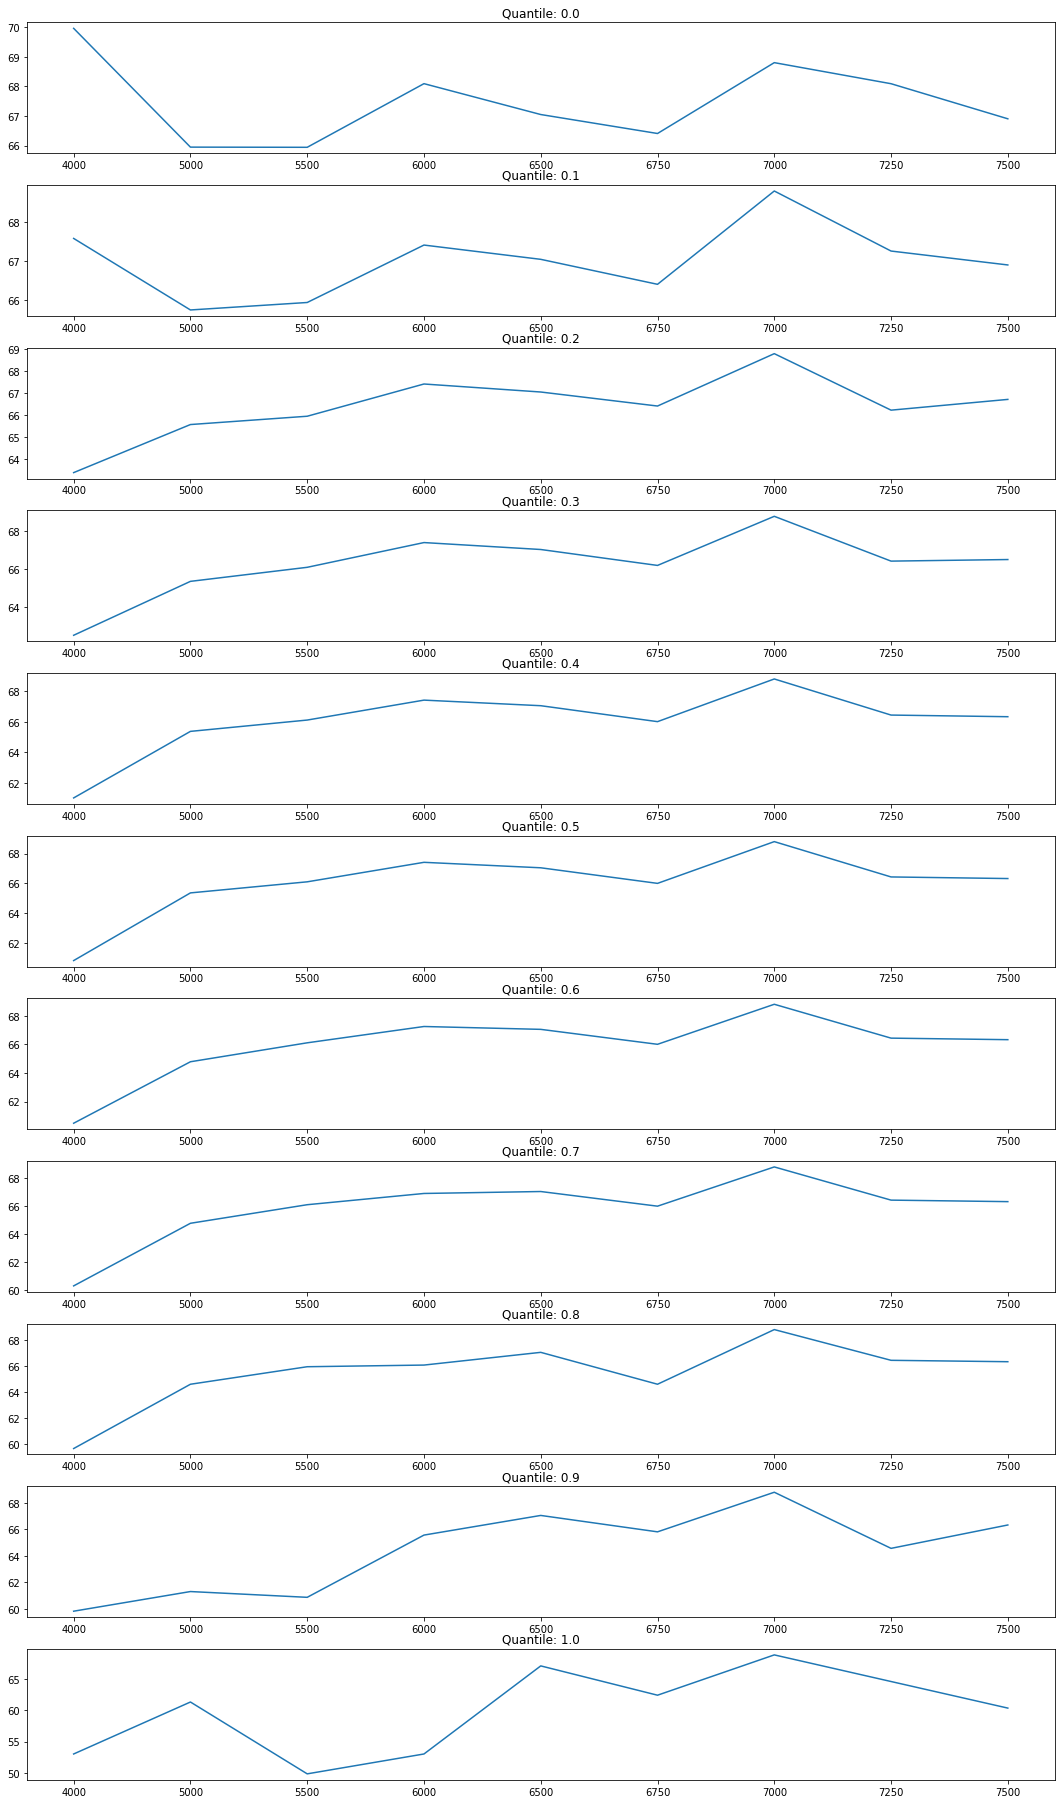

In [6]:
f, axes = plt.subplots(nrows=len(quantiles), figsize=(15, 25))
f.tight_layout()
for ax, (quantile, covers) in zip(axes, covers_all.items()):
    ax.set_title(f'Quantile: {quantile}')
    ax.plot(list(covers.keys()), list(covers.values()))

In [ ]:
f.savefig('coverage_crossover.pdf')

In [7]:
f.savefig('coverage_crossover.pdf')